In [ ]:
using KnetLayers, Random, Plots, DataFrames, StatsPlots, Query, PlotThemes, CSV
import KnetLayers: IndexedDict, arrtype, nllmask
setoptim!(M, optimizer) = for p in params(M); p.opt = deepcopy(optimizer); end
gpu(0)
KnetLayers.gc()

In [ ]:
pyplot()
theme(:ggplot2)
ENV["COLUMNS"] = 500
ENV["LINES"]   = 100

In [ ]:
vocab    = IndexedDict([collect('0':'9'); collect('a':'z')])
digits   = '0':2:'8'
chars    = 'a':'h'
holdout  = ['0' .* ('a':'b'); '2'.*('c':'d'); '4'.*('e':'f'); '8'.*('g':'h'); "6h"]
data     = [d*c for d in digits, c in chars if d*c ∉ holdout ]

In [ ]:
𝑿 = [vocab[collect(d)] for d in data]
V = length(vocab)

In [ ]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
interact(e,h,W)     = softmax(e .* (W * h))
drop(x)             = dropout(x, 0.5)
function attend(e,h,W,layer) 
    α = interact(e,h,W)
    layer(sum(drop(α .* h), dims=2)), α 
end
function encode(model, xi, 𝑿╲i=nothing)
    e   = drop(vec(model.encoder(xi))) # 2H
    if isnothing(𝑿╲i)
        model.Wμ(e), model.Wσ(e), nothing
    else          
        h          = drop(mat(model.encoder(𝑿╲i))) # H x 2 x (T-1)
        μ, αμ      = attend(e,h,model.Wμa.weight,model.Wμ)
        logσ², ασ  = attend(e,h,model.Wσa.weight,model.Wσ)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿╲i=nothing)
    if !isnothing(𝑿╲i)
        h      = mat(drop(model.encoder(𝑿╲i)))  # H x 2 x (T-1)
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), nothing
    end
end
    

isencatt(model)    = haskey(model, :Wμa) &&  haskey(model, :Wσa) 
isdecatt(model)    = haskey(model, :Wza) 
hiddensize(model)  = size(model.encoder.weight,1)
elementtype(model) = eltype(model.encoder.weight)

In [ ]:
function loss(model, xi, 𝑿╲i; encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿╲i : nothing))
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿╲i : nothing))
    KL = -sum(1 .+ logσ² .- μ.^2 .- σ²)/ 2length(μ)
    L  = nll(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end

function eval(model, vocab, 𝑿)
    results  = Dict()
    for i=1:length(𝑿)
        xi  = 𝑿[i]
        𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end]]...)
        L, y, att = loss(model, xi,  𝑿╲i; encatt=isencatt(model), decatt=isdecatt(model), results=true)
        results[xi] = (L=L,y=y,att=att)
    end
    decres = empty(results)
    for (k,v) in results
        decres[join(vocab[k])] = (L=v.L,y=join(vocab[v.y]), att = v.att)
    end
    return decres
end

function train!(model, 𝑿; epoch=20, optim=Adam())
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        for (i,xi) in enumerate(shuffle(𝑿))
            xi   = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end] ]...)
            J = @diff loss(model, xi, 𝑿╲i, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

In [ ]:
function samplingparams(model, 𝑿; useprior=false)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for i=1:length(𝑿)
            xi  = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1];𝑿[i+1:end]]...)
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? 𝑿╲i : nothing)
            μ  .+= μi
            σ² .+= exp.(logσ²)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    σ  = sqrt.(σ²)
    𝑿 =  hcat(𝑿...)
    samples = []
    for i=1:N
        z     = μ .+ randn!(similar(μ)) .* σ
        xp, _ = decode(model, z, (isdecatt(model) ? 𝑿 : nothing))
        push!(samples,join(vocab[greedy(xp)]))
    end
    return samples
end

In [ ]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
# interact_b(e,h,mask::Nothing) = softmax(e .* h, dims=(1,2))
# drop(x) = dropout(x, 0.5)
function interact(e, h; mask=nothing, sumout=false)
    y = isnothing(mask) ?  (e .* h) : ( e .* h .+ mask)
    if sumout
        α = softmax(mat(sum(y,dims=1)),dims=1)
        reshape(α,1,size(α)...)
    else
        softmax(y, dims=(1,2))
    end
end

function attend(e, h, W, layer, mask=nothing; sumout=false) 
    h3d = reshape(W*h, size(h,1),size(h,2),1)
    h   = reshape(h, size(h,1),size(h,2),1)
    α   = interact(e,h3d; mask=mask, sumout=sumout)  
    layer(mat(sum(drop(α .* h), dims=2))), α 
end

function encode(model, xi, 𝑿=nothing, mask=nothing)
    e = drop(model.encoder(xi))
    H,N,B = size(e)
    if isnothing(𝑿)
        e = reshape(e,H*N,B)
        model.Wμ(e), model.Wσ(e), nothing
    else   
        e = reshape(e,H*N,1,B)
        h  = drop(mat(model.encoder(𝑿))) # 2H x  L
        μ, αμ    = attend(e,h,model.Wμa.weight,model.Wμ, mask)
        logσ², ασ = attend(e,h,model.Wσa.weight,model.Wσ, mask)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿=nothing, mask=nothing)
    if !isnothing(𝑿)
        h      = mat(drop(model.encoder(𝑿)))  # 2H x B
        zi     = reshape(zi,size(zi,1),1,size(zi,2))
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz, mask)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), nothing
    end
end


function loss(model, xi, 𝑿; mask=nothing, encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿 : nothing), mask)
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿 : nothing), mask)
    KL = -sum(1.0f0 .+ logσ² .- μ.^2 .- σ²) / 2length(μ)
    L  = nllmask(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end


function get_mask(indices,L)
    B = length(indices)
    mask = zeros(Float32,1,L,B)
    for (i,ind) in enumerate(indices)
        mask[1,ind,i] = -1.0f30
    end
    return arrtype(mask)
end
    

batches(X,B) = [collect(i:i+B-1) for i=1:B:length(X)-B+1]

    
function train!(model, 𝑿; epoch=20, optim=Adam(), B=2)
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        X = shuffle(𝑿)
        for (i,indices) in enumerate(batches(X,B))
            xi   = hcat(X[indices]...)
            xt   = hcat(X...)
            mask = get_mask(indices,length(X))
            J = @diff loss(model, xi, xt, mask=mask, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

In [ ]:
function samplingparams(model, 𝑿; useprior=false, B=2)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for (i,indices) in enumerate(batches(𝑿,B))
            xi   = hcat(𝑿[indices]...)
            xt   = hcat(𝑿...)
            mask = get_mask(indices,length(𝑿))
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? xt : nothing, mask)
            μ  .+= sum(μi,dims=2)
            σ² .+= sum(exp.(logσ²),dims=2)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

greedy(y) = mapslices(argmax, y, dims=1)
function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    xt    =  hcat(𝑿...)
    r     =  similar(μ,size(μ,1),N)
    z     =  μ .+ randn!(r) .* sqrt.(σ²)
    xp, _ =  decode(model, z, (isdecatt(model) ? xt : nothing),  nothing)
    vec(mapslices(x->join(vocab[greedy(x)]), convert(Array, xp), dims=(1,2)))
end

In [ ]:
cmodel = get_vae_models(256)[3]
train!(cmodel, 𝑿; epoch=30, optim=Adam(),B=2)
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]   
unique(unseen)
# push!(df2, (isencatt(cmodel), isdecatt(cmodel), H, opt.lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong),length(unique(unseen)) ))
# print((row+=1), " ")

In [ ]:
function probmap(y)
    u=unique(y)
    Dict([(i,count(x->x==i,y) / length(y)) for i in u])
end

In [ ]:
function get_vae_models(H=256)
    encoder    = Embed(input=V,output=H)
    decoder    = Embed(input=H,output=V)
    Wμa        = Multiply(input=2H,output=2H)
    Wμ         = Dense(input=2H,output=2H, activation=ELU())
    Wza        = Multiply(input=2H,output=2H)
    Wz         = Dense(input=2H,output=2H, activation=ELU())
    Wσa        = Multiply(input=2H,output=2H)
    Wσ         = Dense(input=2H,output=2H, activation=ELU())
    model_atte = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, decoder=decoder)
    model_vae  = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσ=Wσ, decoder=decoder)
    model_attd = (encoder=encoder, Wμ=Wμ, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    model_attde = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    (model_vae, model_atte, model_attd, model_attde);
end

In [153]:
df2 = DataFrame(EncoderAtt = Bool[], DecoderAtt = Bool[], B=Int[], H = Int[], lr=Float64[], Optimizer = String[], Epoch = Int[], UnseenCnt=Int[], MissedClass=Int[], WrongCount=Int[])

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64


In [ ]:
row = 0
for H in (256,128)
    for opt in (Adam, Rmsprop, SGD)
        for lr in (0.001, 0.01, 0.1, 1.0)
            for B in (1,2,4,8,16)
                for epoch in (10,20,30)
                    for model in get_vae_models(H)
                        cmodel = deepcopy(model)
                        train!(cmodel, 𝑿; epoch=epoch, optim=opt(lr=lr))
                        sampled = sample(cmodel, vocab, 𝑿; N=100)
                        unseen = [s for s in sampled if s ∈ holdout]
                        wrong  = [s for s in sampled if s ∉ [data;holdout]]              
                        push!(df2, (isencatt(cmodel), isdecatt(cmodel), B, H, lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong)))
                        print((row+=1), " ")
                    end
                end
           end
        end
    end
end
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 

In [17]:
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

In [157]:
df3 = df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount,UnseenClass
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64,Int64
1,0,0,4,256,0.001,Rmsprop,20,23,0,0,9
2,1,0,1,256,0.01,Rmsprop,20,21,0,0,9
3,1,0,4,256,0.01,Rmsprop,10,27,0,0,9
4,1,0,2,128,0.01,Rmsprop,10,20,0,0,9
5,1,0,16,128,0.01,Rmsprop,30,26,0,0,9
6,1,0,2,128,0.1,SGD,20,18,0,0,9
7,0,0,8,256,0.001,Adam,10,23,0,1,9
8,1,0,2,256,0.01,Adam,30,20,0,1,9
9,1,0,4,256,0.01,Adam,20,23,0,1,9


In [146]:
cmodel = get_vae_models(128)[2]
train!(cmodel, 𝑿; epoch=60, optim=Adam())
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]
result = eval(cmodel, vocab, 𝑿)

Dict{Any,Any} with 31 entries:
  "4a" => (L = 2.30187, y = "6b", att = (αe = (αμ = K32(256,30)[1.8441857e-5⋯], ασ = K32(256,30)[4.5115175e-5⋯]), αd = nothing))
  "4d" => (L = 1.86366, y = "0c", att = (αe = (αμ = K32(256,30)[1.749927e-5⋯], ασ = K32(256,30)[4.5498175e-5⋯]), αd = nothing))
  "6d" => (L = 0.929366, y = "6d", att = (αe = (αμ = K32(256,30)[1.9662112e-7⋯], ασ = K32(256,30)[4.431309e-7⋯]), αd = nothing))
  "6b" => (L = 1.87, y = "8h", att = (αe = (αμ = K32(256,30)[2.0375037e-7⋯], ασ = K32(256,30)[4.5178157e-7⋯]), αd = nothing))
  "6e" => (L = 1.18254, y = "4b", att = (αe = (αμ = K32(256,30)[1.9590901e-7⋯], ασ = K32(256,30)[4.5182693e-7⋯]), αd = nothing))
  "6a" => (L = 1.77329, y = "8f", att = (αe = (αμ = K32(256,30)[1.902861e-7⋯], ασ = K32(256,30)[4.3968257e-7⋯]), αd = nothing))
  "2h" => (L = 1.78155, y = "2d", att = (αe = (αμ = K32(256,30)[9.932463e-7⋯], ασ = K32(256,30)[7.224869e-7⋯]), αd = nothing))
  "2g" => (L = 0.947404, y = "2a", att = (αe = (αμ = K32(256,30)[1.027027

In [148]:
unique(unseen)

6-element Array{String,1}:
 "8g"
 "4e"
 "4f"
 "2d"
 "0b"
 "2c"

In [150]:
for (k,v) in result
    if k==v.y
        println(v)
    end
end

(L = 0.92936647f0, y = "6d", att = (αe = (αμ = K32(256,30)[1.9662112e-7⋯], ασ = K32(256,30)[4.431309e-7⋯]), αd = nothing))
(L = 0.8953346f0, y = "4c", att = (αe = (αμ = K32(256,30)[1.828638e-5⋯], ασ = K32(256,30)[4.588832e-5⋯]), αd = nothing))


In [152]:
inp = "4h"
v = result[inp]
StatsPlots.bar(v.y, sum(v.att.αe.αμ, dims=1), xticks=(0.5:1:length(v[2])-0.5, v[2]), title="$inp->$(v[1])", size=(1200,300))

ErrorException: Cannot convert String to series data for plotting

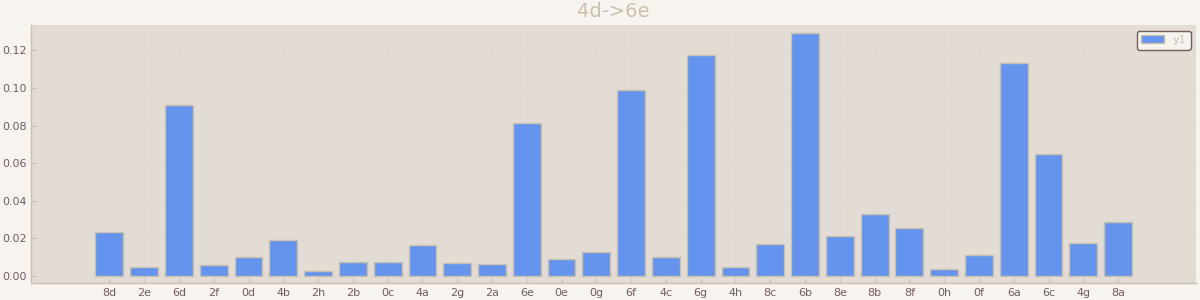

In [41]:
inp = "4d"
v = d[inp]
StatsPlots.bar(1:length(v[4]), v[3], xticks=(1:length(v[2]), v[2]), title="$inp->$(v[1])", size=(1200,300))

In [ ]:
df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :UnseenClass , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :WrongCount , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
E = 64
H = 256

In [ ]:
forw(lmmodel,x; start_tok=length(vocab)) = lmmodel.output(lmmodel.rnn([length(vocab);x]').y)
loss(lmmodel,x) = nll(forw(lmmodel,x),[x;0])
    
function predict(lmmodel,len; start_tok=length(vocab))
    ys = zeros(Int,len)
    input = start_tok
    for i=1:len
        yi = lmmodel.output(lmmodel.rnn([input]).y)
        input = catsample(softmax(yi)) # put a random sampling here
        ys[i] = input
    end
    return ys
end

function train!(model, x_onehot; epoch=20, optim=Adam())
    setoptim!(model,optim)
    for i=1:epoch
        lss = 0.0
        cnt = 0
        x_onehot = shuffle(x_onehot)
        for i=1:length(x_onehot)
            x  = x_onehot[i]
            J = @diff loss(model,  x)
            lss += value(J)
            cnt += 1
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end
        end
    end
end

function catsample(p)
    p = convert(Array,p)
    r = rand()
    for c = 1:length(p)
        r -= p[c]
        r < 0 && return c
    end
end

In [ ]:
lmmodel = (rnn=LSTM(input=V,hidden=H,embed=E,dropout=0.5), output=Linear(input=H,output=V))

In [ ]:
train!(lmmodel,x_onehot; optim=Adam(lr=0.01))

In [ ]:
loss(lmmodel,x_onehot[1])

In [ ]:
sampled =[vocab[predict(lmmodel,2)] for i=1:100];

In [ ]:
unseen = [join(s) for s in sampled if join(s) ∈ holdout]
wrong  = [join(s) for s in sampled if join(s) ∉ [data;holdout]]
dkl = KLDivergence(data,holdout,sampled)               

In [ ]:
unseen